In [9]:
from IPython.display import Image, display
from langgraph.graph import END, START, StateGraph
from typing_extensions import TypedDict
from _constants import LLM_CONFIGS
from langchain_ollama import ChatOllama
from langchain_core.messages import HumanMessage, SystemMessage


# Example - Prompt Chaining

In [2]:
# Graph state
class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str

In [3]:
llm = ChatOllama(
    model=LLM_CONFIGS["llama3.2"]["model"]
)

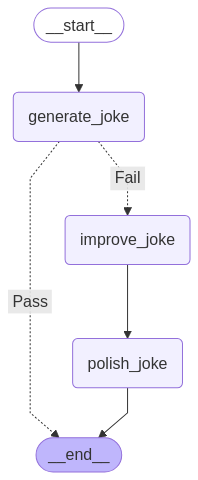

In [4]:
# Nodes
def generate_joke(state: State):
    """First LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke about {state['topic']}")
    return {"joke": msg.content}


def check_punchline(state: State):
    """Gate function to check if the joke has a punchline"""

    # Simple check - does the joke contain "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Fail"
    return "Pass"


def improve_joke(state: State):
    """Second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    return {"improved_joke": msg.content}


def polish_joke(state: State):
    """Third LLM call for final polish"""

    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {"final_joke": msg.content}


In [ ]:
# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges(
    "generate_joke", check_punchline, {"Fail": "improve_joke", "Pass": END}
)
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile
chain = workflow.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

In [5]:
# Invoke
state = chain.invoke({"topic": "cats"})
print("Initial joke:")
print(state["joke"])
print("\n--- --- ---\n")
if "improved_joke" in state:
    print("Improved joke:")
    print(state["improved_joke"])
    print("\n--- --- ---\n")

    print("Final joke:")
    print(state["final_joke"])
else:
    print("Joke failed quality gate - no punchline detected!")


Initial joke:
Why did the cat join a band?

Because it wanted to be the purr-cussionist.

--- --- ---

Improved joke:
Here's an attempt at adding wordplay:

Why did the cat join a band?

Because it heard the drums were 'paw-some' and wanted to become the purr-cussionist – but little did it know, it was just the cat's meow on stage!

In this version, I've added a few layers of wordplay:

1. "Paw-some" is a play on the word "awesome" that incorporates the idea of a cat's paw.
2. The phrase "the cat's meow" is an idiom that means something or someone is excellent or desirable, but in this context, it's also a clever pun on the fact that cats are known for their distinctive meowing sound.

Let me know if you'd like me to try any further adjustments!

--- --- ---

Final joke:
I love where you're going with this joke. Here's a suggestion for adding another layer of wordplay:

Why did the cat join a band?

Because it heard the drums were 'paw-some' and wanted to become the purr-cussionist – b

Rough RRA Workflow - Prompt Chaining

In [6]:
#memory = MemorySaver()

In [7]:
# Graph state
class State(TypedDict):
    user_proposal: str
    risk_assessment_and_rating: str
    proposal_feedback: str
    improved_proposal: str

In [8]:
llm = ChatOllama(
    model=LLM_CONFIGS["llama3.2"]["model"]
)

In [11]:
# Nodes
def risk_assessment(state: State):
    """First LLM call to provide a risk assessment of the user proposal"""

    msg = llm.invoke(
        [
            SystemMessage(content="You are a FDA regulatory reviewer. Provide a risk \
                assessment of the user submission and detail specific flaws in the application\
                    that would not pass regulatory approval. Provide an overall summary and a rating \
                        from 1 to 10."),
            HumanMessage(content=f"Review this proposal and provide a rating: {state['user_proposal']}")
        ]
    )
    
    return {"risk_assessment_and_rating": msg.content}


def check_rating(state: State):
    """Gate function to check if the risk rating is = 5 out of 10"""

    # Simple check - does the joke contain "?" or "!"
    if "5" in state["risk_assessment_and_rating"]:
        return "Fail"
    return "Pass"


def regulatory_risk_critquer(state: State):
    """Second LLM call to provide specific feedback based on different categories of regulatory approval to improve the rating."""

    #msg = llm.invoke(f"Make this joke funnier by adding wordplay: {state['joke']}")
    msg = llm.invoke(
        [
            SystemMessage(content="You are an expert regulatory critiquer. \
                            Given the risk assessment and rating, propose \
                                changes and explain why to make these changes to improve the original proposal.\
                                Also provide an alternative approach for how they can rework their proposal to a different population or other strategies you can think of for better success \
                                    Give the final result in bullet points summary for each of these categories. \
                                    1) Mechanistic Risk 2) Biomarker Asessment 3) Endpoint Alignment 4) Safety."),
            HumanMessage(content=f"Here is the original proposal: {state['user_proposal']}. Here is the risk assessment \
                and rating: {state['risk_assessment_and_rating']}")
        ]
    )
    return {"proposal_feedback": msg.content}


def proposal_writer(state: State):
    """Third LLM call for writing a new proposal based on feedback."""

    #msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    msg = llm.invoke(
        [
            SystemMessage(content="You are an expert FDA regulatory writer. \
                            Given the feedback for approval, rewrite the original proposal with the appropriate changes. \
                                Provide a 200-word new proposal well-written incorporating the changes"),
            HumanMessage(content=f"Here is the original proposal: {state['user_proposal']}. Here is the risk assessment \
                and rating: {state['risk_assessment_and_rating']}. Here is the proposal feedback: {state['proposal_feedback']}")
        ]
    )
    return {"improved_proposal": msg.content}


In [14]:
# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("risk_assessment", risk_assessment)
workflow.add_node("regulatory_risk_critquer", regulatory_risk_critquer)
workflow.add_node("proposal_writer", proposal_writer)

# Add edges to connect nodes
workflow.add_edge(START, "risk_assessment")
workflow.add_conditional_edges(
    "risk_assessment", check_rating, {"Fail": "regulatory_risk_critquer", "Pass": END}
)
workflow.add_edge("regulatory_risk_critquer", "proposal_writer")
workflow.add_edge("proposal_writer", END)

# Compile
chain = workflow.compile()



In [15]:
# Show workflow
display(Image(chain.get_graph().draw_mermaid_png()))

ValueError: Failed to reach https://mermaid.ink/ API while trying to render your graph. Status code: 502.

To resolve this issue:
1. Check your internet connection and try again
2. Try with higher retry settings: `draw_mermaid_png(..., max_retries=5, retry_delay=2.0)`
3. Use the Pyppeteer rendering method which will render your graph locally in a browser: `draw_mermaid_png(..., draw_method=MermaidDrawMethod.PYPPETEER)`

In [17]:
# Invoke
user_prompt = "This proposed FDA label describes Respilimab, a humanized monoclonal antibody \
    targeting IL-13, for treatment of moderate-to-severe eosinophilic asthma. It outlines dosing \
        (300 mg subcutaneous every 4 weeks), safety data, and trial outcomes showing improved lung \
            function and reduced exacerbations, supporting use in patients uncontrolled on standard inhaled therapies."

state = chain.invoke({"user_proposal": user_prompt})
print("Initial review:")
print(state["risk_assessment_and_rating"])
print("\n--- --- ---\n")
if "proposal_feedback" in state:
    print("proposal_feedback:")
    print(state["proposal_feedback"])
    print("\n--- --- ---\n")

    print("improved_proposal:")
    print(state["improved_proposal"])
else:
    print("Proposal failed quality gate - lower than 5 threshold!")
    
    


Initial review:
**Risk Assessment and Flaws:**

1. **Lack of detailed mechanistic information**: The proposal does not provide sufficient evidence on the specific mechanisms by which Respilimab reduces eosinophilic asthma symptoms. A clear explanation of how the antibody works is essential to understand its therapeutic effects.
2. **Insufficient data on adverse events**: The proposal only mentions safety data without providing a comprehensive analysis of adverse event profiles, including frequency, severity, and potential long-term consequences. This omission raises concerns about the potential risks associated with Respilimab use.
3. **Inadequate comparisons to existing treatments**: The trial outcomes are presented as isolated results, but the proposal does not adequately compare Respilimab to established treatments for eosinophilic asthma, such as omalizumab or mepolizumab. A thorough comparison would help demonstrate its unique benefits and risks.
4. **Unclear patient population ch